In [2]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.metrics import root_mean_squared_log_error

from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor

from utils import *

# 👀👀 Set Matplotlib defaults
plt.style.use("seaborn-v0_8-whitegrid")
plt.rc("figure", autolayout=True, figsize=(16, 7))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'

# list all files in data folder
import os
for dirname, _, filenames in os.walk('data/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


data/test.csv
data/train.csv
data/transactions.csv
data/oil.csv
data/holidays_events.csv
data/sample_submission.csv
data/stores.csv


In [2]:
# import warnings

# # Ignore all FutureWarnings
# warnings.filterwarnings('ignore', category=FutureWarning)

# # Ignore all DeprecationWarnings
# warnings.filterwarnings('ignore', category=DeprecationWarning)

# print("plotp")

----
### pour plus tard

In [4]:
file_path = dir_path + "oil.csv"

df_oil = pd.read_csv(
    file_path,
    parse_dates=['date'])

df_oil

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20
...,...,...
1213,2017-08-25,47.65
1214,2017-08-28,46.40
1215,2017-08-29,46.46
1216,2017-08-30,45.96


----
### data preparation

In [5]:
dir_path = "data/"

In [6]:
file_path = dir_path + "train.csv"

df_sales = pd.read_csv(
    file_path,
    usecols=['store_nbr', 'family', 'date', 'sales'],
    dtype= {
        'store_nb':    'category',
        'family':      'category',
        'sales':       'float',
        'onpromotion': 'uint32'
        },
    parse_dates= ['date'],
)
 
df_sales['date'] = df_sales.date.dt.to_period('D')
#df_sales = df_sales.set_index('id')

df_sales = df_sales.set_index(['store_nbr', 'family', 'date']).sort_index()  # a voir quel index on garde


#---------------------------------------------------------------------------
df_average_sales_train = (
    df_sales
    .groupby('date').mean()
    .squeeze()  # transform dataframe single column in Series
    .loc['2013-01-01' : '2015-12-31']
)

df_average_sales_test = (
    df_sales
    .groupby('date').mean()
    .squeeze()  # transform dataframe single column in Series
    .loc['2016-01-01' : '2016-01-15']
)



df_average_sales_test



# chelou, il manque des 25 dec (et peut etre d'autres dates ??)  >> le rajouter en mettant tout à 0 ?



date
2016-01-01      9.221882
2016-01-02    598.584414
2016-01-03    688.403883
2016-01-04    536.451670
2016-01-05    468.754455
2016-01-06    461.103062
2016-01-07    366.725234
2016-01-08    400.453611
2016-01-09    555.111929
2016-01-10    614.306306
2016-01-11    395.900809
2016-01-12    363.108003
2016-01-13    370.395801
2016-01-14    315.360619
2016-01-15    376.558418
Freq: D, Name: sales, dtype: float64

In [7]:
file_path = dir_path + "holidays_events.csv"


df_holidays = pd.read_csv(
    file_path,
    dtype={
        'type': 'category',
        'locale': 'category',
        'locale_name': 'category',
        'description': 'category',
        'transferred': 'bool',
    },
    parse_dates=['date'],
)
df_holidays = df_holidays.set_index('date').to_period('D')



df_holidays

## a terminer, un peu de trucs à comprendre je pense

,type,locale,locale_name,description,transferred
date,,,,,
2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False
...,...,...,...,...,...
2017-12-22,Additional,National,Ecuador,Navidad-3,False
2017-12-23,Additional,National,Ecuador,Navidad-2,False
2017-12-24,Additional,National,Ecuador,Navidad-1,False


In [8]:
# National and regional holidays in the training set
df_holidays_light = (
    df_holidays
    .query("locale in ['National', 'Regional']")
    .loc['2013-01-01' : '2016-01-15', ['description']]
    .assign(description=lambda x: x.description.cat.remove_unused_categories())
)

print(len(df_holidays_light))

# remove 25th december cuz not in df,   = c'est un pansement provisoir, il faut corriger à la source je pense (?) !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
df_holidays_light = df_holidays_light[~( (df_holidays_light.index.day   == 25)
                                        &(df_holidays_light.index.month == 12))]


# attention y'a des duplicates !!  >>>>>>>  corriger mieux que ca ! (ou pas :))
df_holidays_light = df_holidays_light[~df_holidays_light.index.duplicated(keep='first')]

print(len(df_holidays_light))

display(df_holidays_light)

96
91


,description
date,
2013-01-01,Primer dia del ano
2013-01-05,Recupero puente Navidad
2013-01-12,Recupero puente primer dia del ano
2013-02-11,Carnaval
2013-02-12,Carnaval
...,...
2015-12-23,Navidad-2
2015-12-24,Navidad-1
2015-12-26,Navidad+1


----------------
### Feature engineering  (trouver le truc auto pr train test en rolling   et rendre plus rigoureux l'utilisation de y vs df)
peut aussi creer sur le full set et faire un left join (comme holidays pr l'instant)     
en fait pour lags, il faut séparer après avoir mis les features (bien plus simple mais faire super attention aux data leaks)

In [9]:
# y ***********************************************

y_train = df_average_sales_train.copy()
y_test  = df_average_sales_test .copy()

In [10]:
# TREND ******************************

dp = DeterministicProcess(
    index=df_average_sales_train.index,
    constant=True,
    order=1
)

X_trend_train = dp.in_sample()
X_trend_test  = dp.out_of_sample(15)

In [11]:
# SEASONNAL **************************************

fourier_year = CalendarFourier(freq='YE', order=4)
fourier_week = CalendarFourier(freq='ME', order=2)

dp = DeterministicProcess(
    index=y_train.index, 
    seasonal= True,
    additional_terms=[fourier_year, fourier_week],
    drop=True,
)

X_season_train = dp.in_sample()
X_season_test  = dp.out_of_sample(15)

In [ ]:
# HOLIDAYS **************************************

X_holidays = pd.get_dummies(df_holidays_light)

In [ ]:
# LAGS *****************************************


X_holidays = pd.get_dummies(df_holidays_light)

X_lags_train = make_lags(y_train, lags=7)

X3 = pd.concat([X2, X_lags], axis=1).dropna()   #removes 1s of january >> ajouter le 31 dec ou carrement toute la série ? ou alors model (time depandant) avant puis apres avoir retiré les Lag (serial dependant)
y, X3 = y.align(X3, join='inner')



# attention : pr l'instant deal pas avec non linéarité (mais pas un pb pour XGB... je sais plus ????)

-----------
### MODEL : linear regression to holidays and XGB for the diff

-----------
### MODEL : linear regression for Trend and XGB for the rest

In [91]:
model = XGBRegressor()
model.fit(X3, y_diff_T)  #betement fait avec X3 mais en fait il faudrait lui faire un X spécial avec numéros de jours, semaine,..., non ? (y'a déja un peu ca en fait non ?)

y_pred_diff = pd.Series(model.predict(X3), index=X3.index)

# align necessary because diff comes from lag and thus has less elements
y_pred_T, y_pred_diff = y_pred_T.align(y_pred_diff, join="inner")  
y       , y_pred_diff = y       .align(y_pred_diff, join="inner") 
y_pred = y_pred_T + y_pred_diff


rmsle = root_mean_squared_log_error(y, y_pred)
print('*'*50)
print(f"RMSLE = {rmsle}")
print('*'*50)


1085
1085
1085
1085
**************************************************
RMSLE = 0.010368903973466402
**************************************************


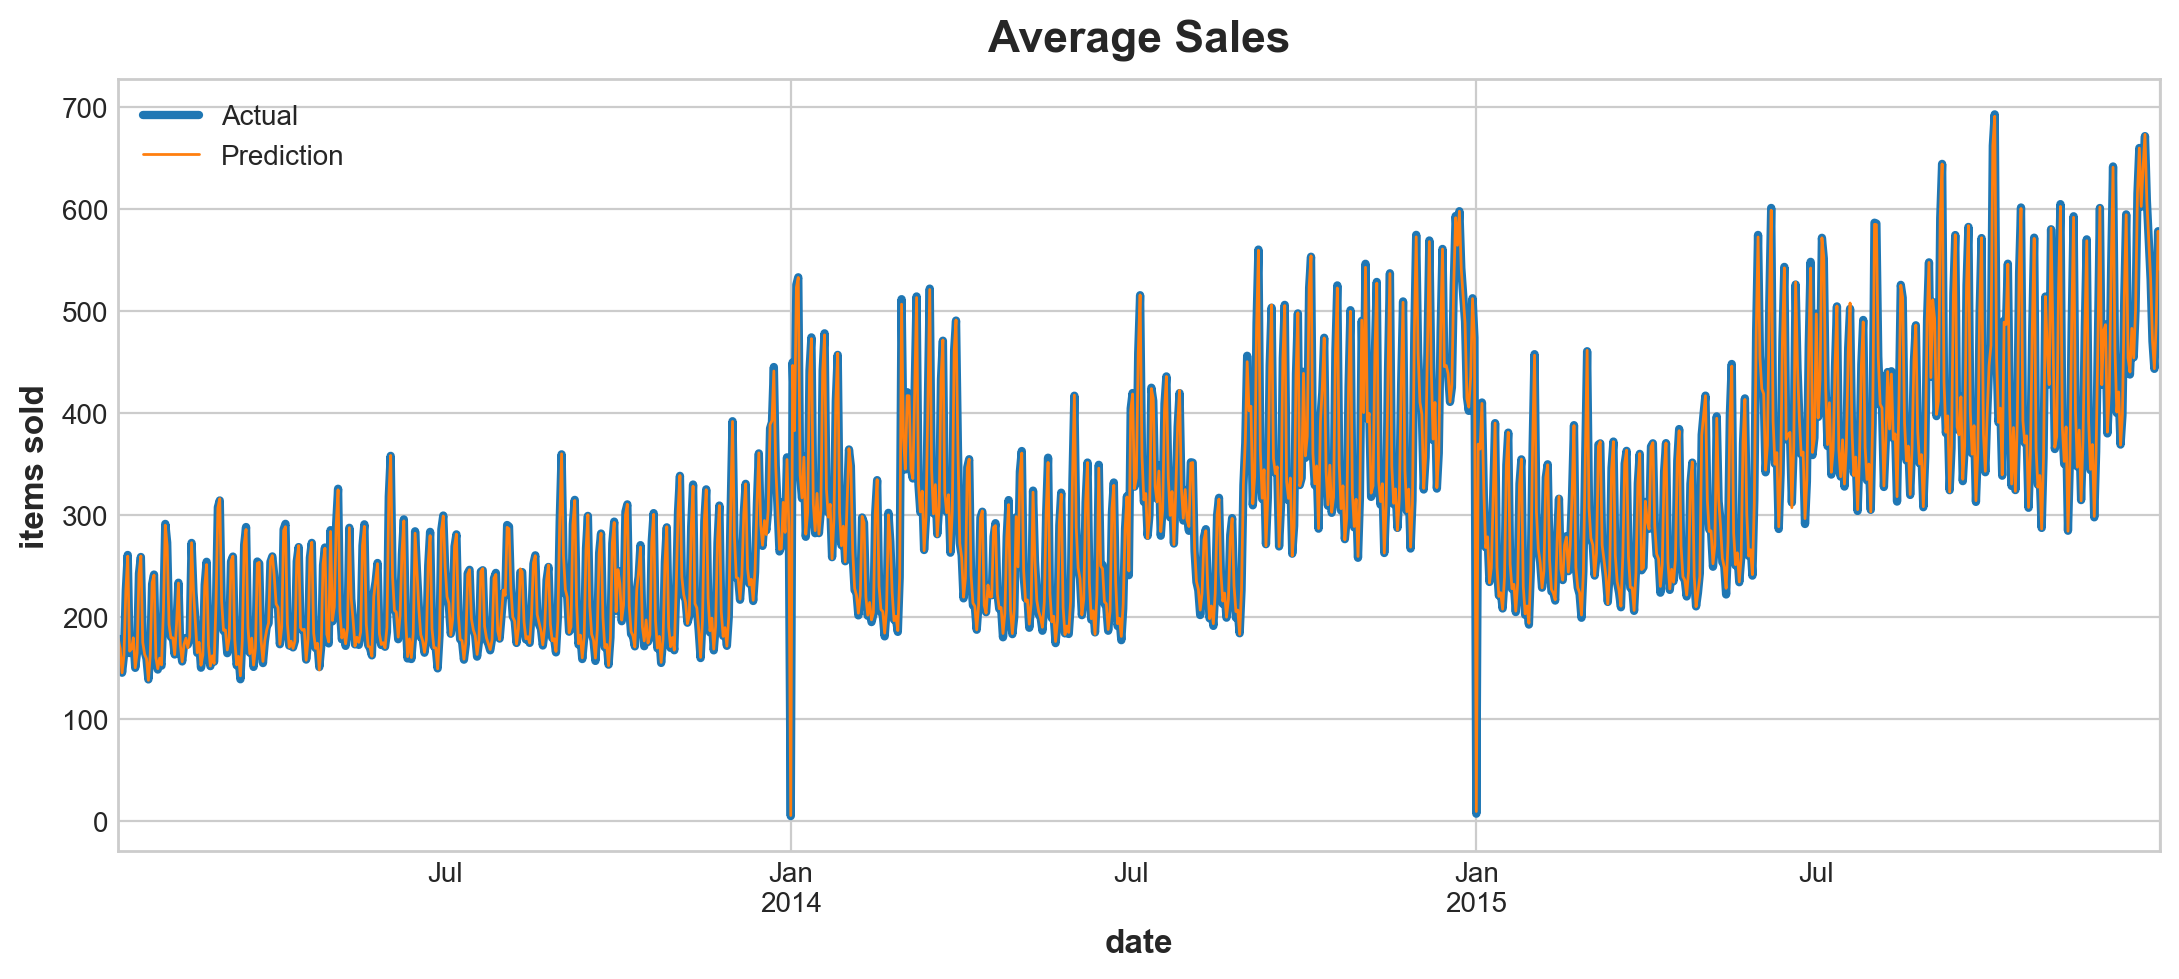

In [98]:
ax = y     .plot(label="Actual",     lw=3, title="Average Sales", ylabel="items sold", )
ax = y_pred.plot(label="Prediction", lw=1, ax=ax, )
ax.legend();

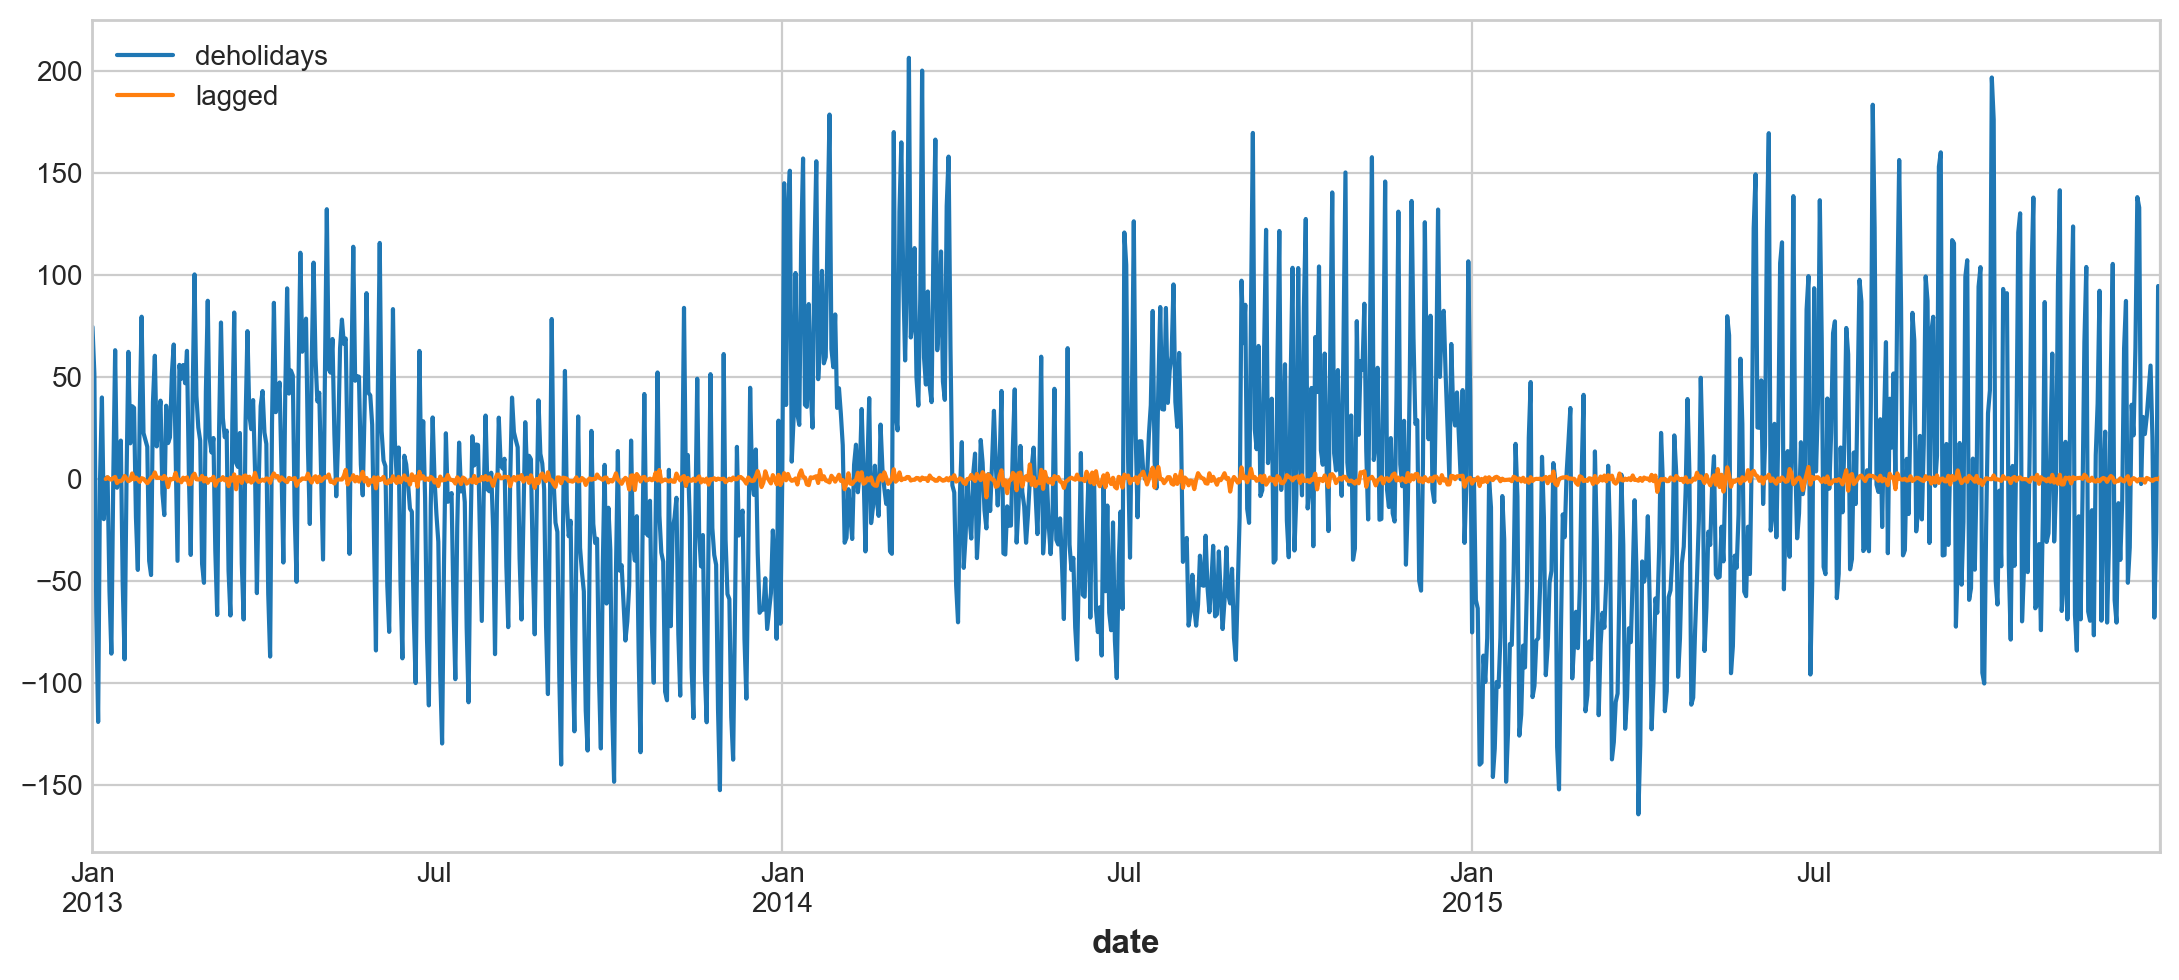

In [102]:
y_diff = y - y_pred

ax = y_deholidays.plot(label='deholidays')
ax = y_diff      .plot(label='lagged',   ax=ax)
ax.legend();

/var/folders/j2/_nb1n_kd24lb5ncqjqw2lrz40000gn/T/ipykernel_23609/1266417359.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_train = X_train.join(X_holidays, how='left').fillna(False)
/var/folders/j2/_nb1n_kd24lb5ncqjqw2lrz40000gn/T/ipykernel_23609/1266417359.py:18: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_test  = X_test .join(X_holidays, how='left').fillna(False)


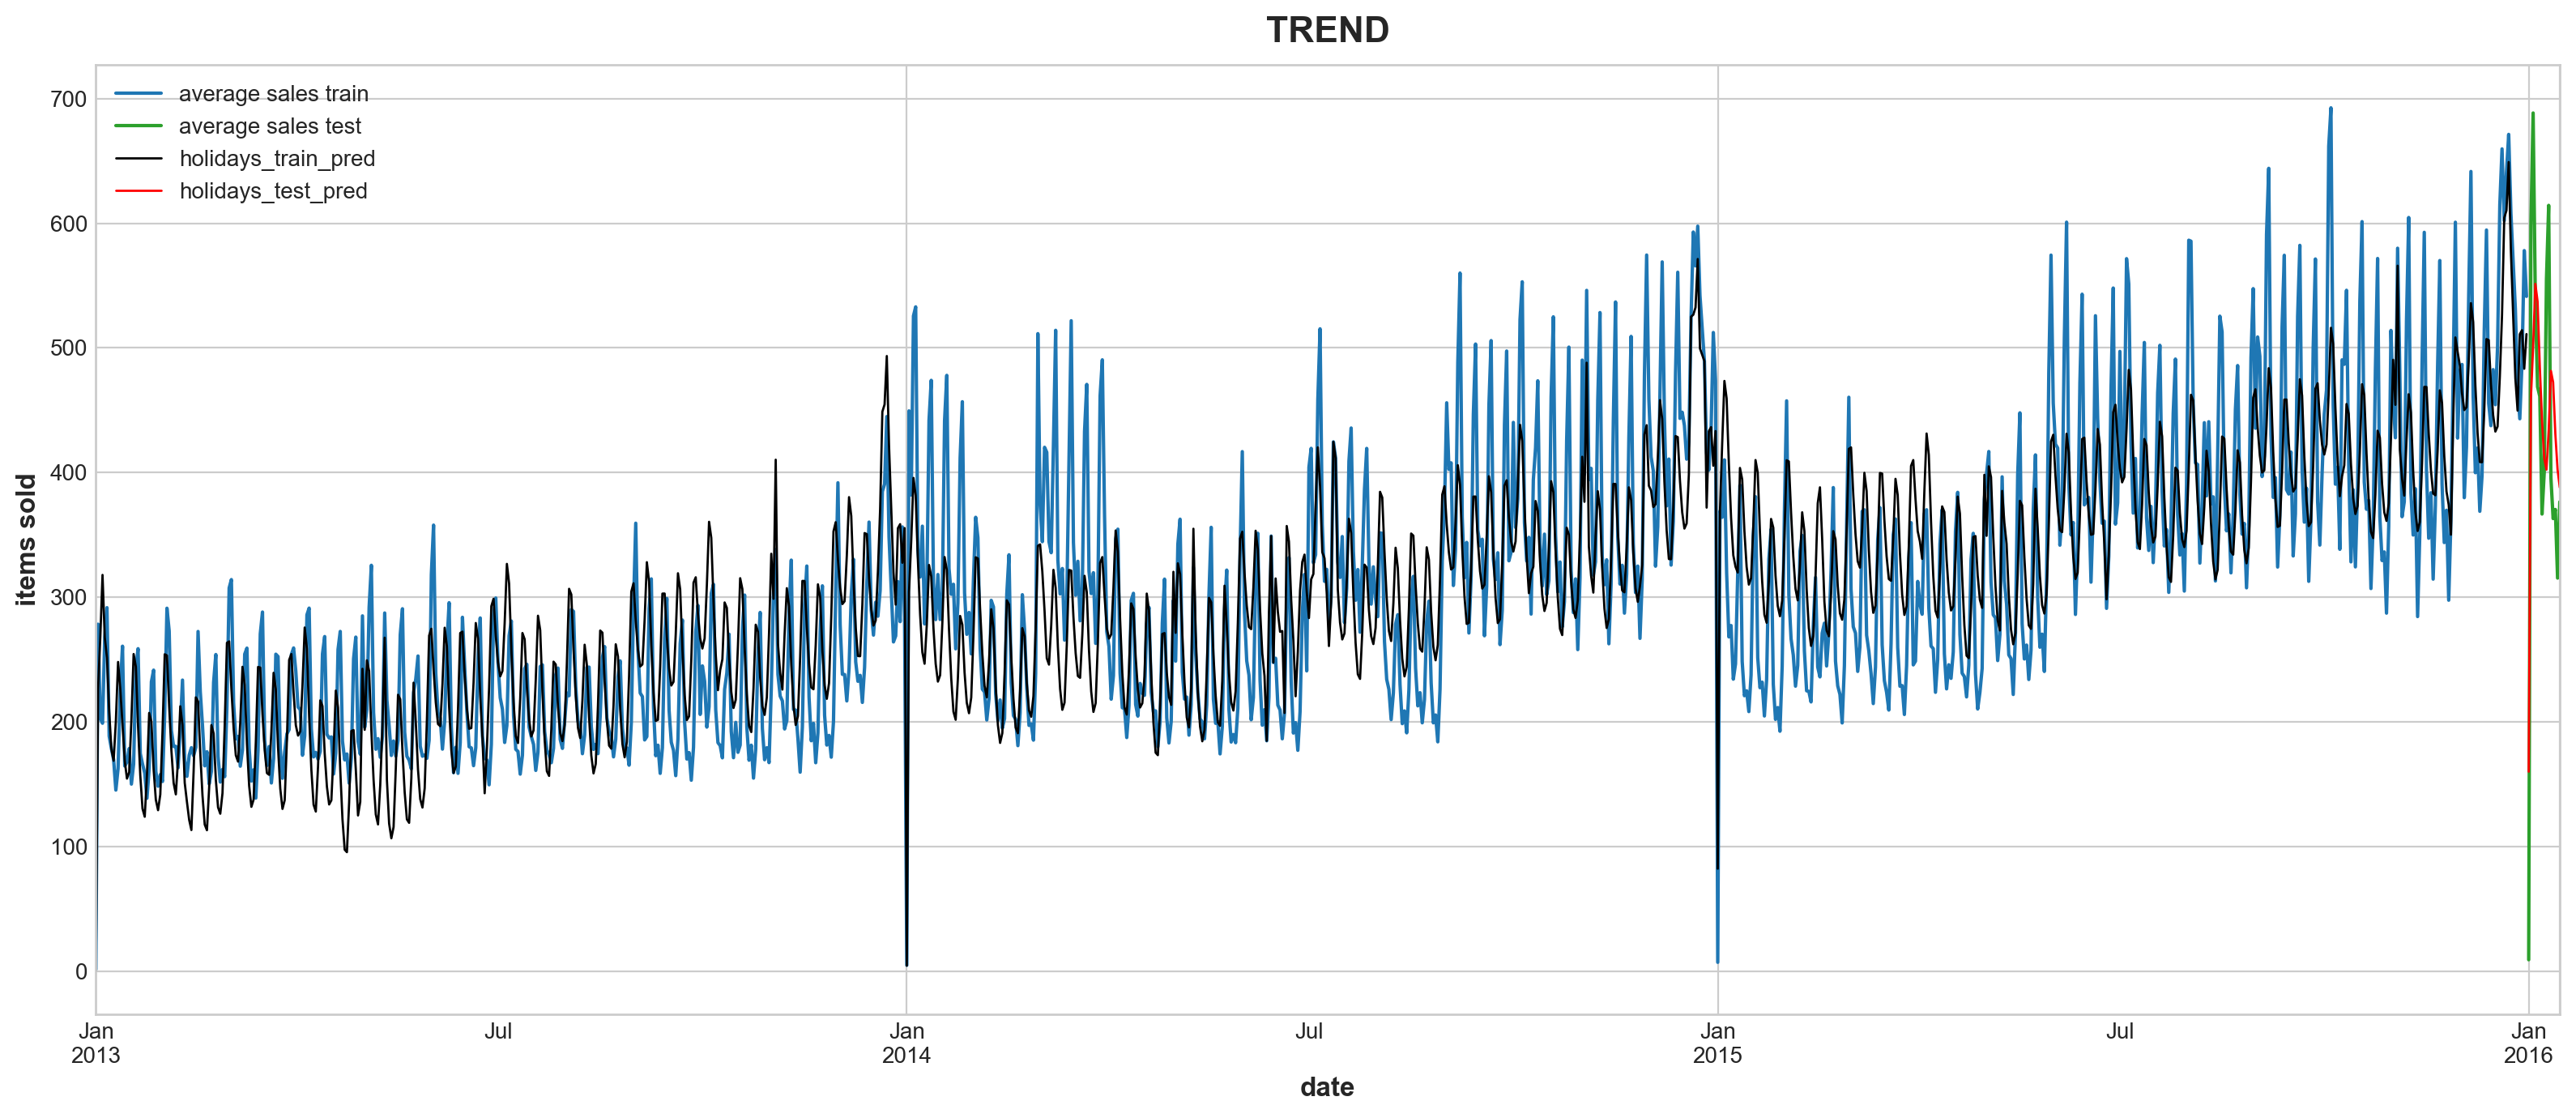

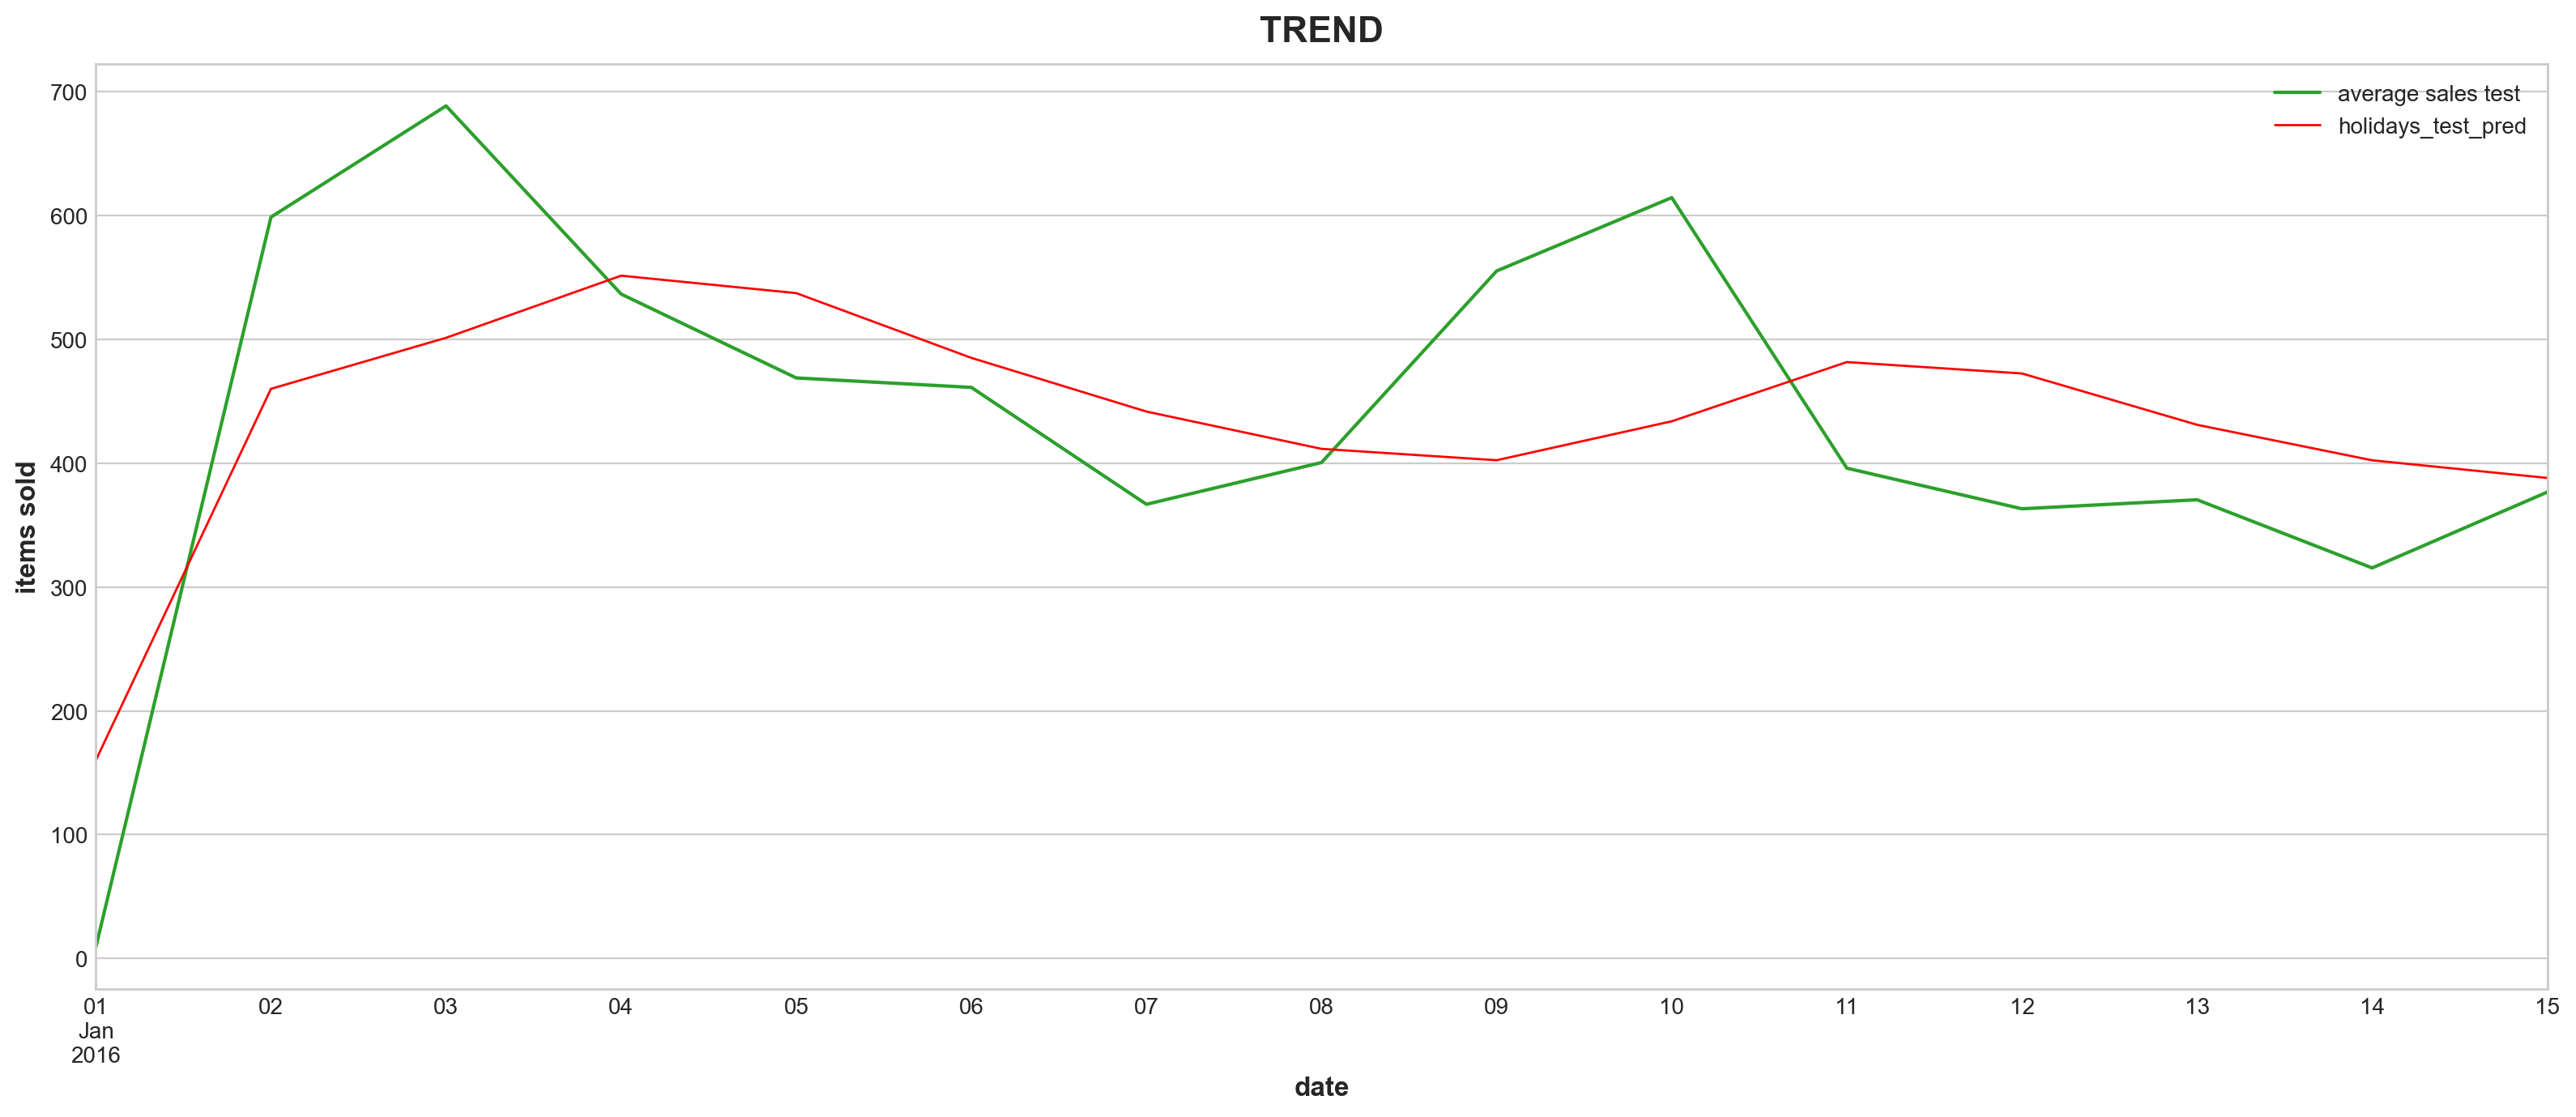

**************************************************
RMSLE train = 0.2244695580474569
**************************************************
**************************************************
RMSLE train = 0.7412926387905868
**************************************************


In [177]:
# Create y ***********************************************

y_train = df_average_sales_train.copy()
y_test  = df_average_sales_test .copy()


# Create X specific **************************************

X_holidays = pd.get_dummies(df_holidays_light)


# Create X complete **************************************

X_train = pd.concat([X_trend_train, X_season_train], axis=1)
X_test  = pd.concat([X_trend_test , X_season_test ], axis=1)

X_train = X_train.join(X_holidays, how='left').fillna(False)
X_test  = X_test .join(X_holidays, how='left').fillna(False)


# Create Model *******************************************

model = LinearRegression()
model.fit(X_train, y_train)


# Make Predictions ***************************************

y_pred_train = pd.Series(model.predict(X_train), index=X_train.index).clip(0.0)
y_pred_test  = pd.Series(model.predict(X_test ), index=X_test .index).clip(0.0)


# plot the results **************************************

ax1 = df_average_sales_train.plot(label="average sales train", color='C10', lw=1.5)
ax1 = df_average_sales_test .plot(label="average sales test" , color='C2',  lw=1.5, ax=ax1)
ax1 = y_pred_train          .plot(label="holidays_train_pred", color='k',   lw=1, ax=ax1)
ax1 = y_pred_test           .plot(label="holidays_test_pred" , color='r',   lw=1, ax=ax1)

ax1.set_title("TREND")
ax1.set_ylabel("items sold")
ax1.legend();

plt.show()

ax2 = df_average_sales_test .plot(label="average sales test" , color='C2',  lw=1.5)
ax2 = y_pred_test           .plot(label="holidays_test_pred" , color='r',   lw=1, ax=ax2)

ax2.set_title("TREND")
ax2.set_ylabel("items sold")
ax2.legend();

plt.show()

# Score the results **********************************


rmsle = root_mean_squared_log_error(y_train, y_pred_train)
print('*'*50)
print(f"RMSLE train = {rmsle}")
print('*'*50)

rmsle = root_mean_squared_log_error(y_test, y_pred_test)
print('*'*50)
print(f"RMSLE train = {rmsle}")
print('*'*50)